In [1]:
import os
import itertools

import copy
from tempfile import mkdtemp
from shutil import rmtree
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core import display as ICD

%matplotlib inline

from scipy.stats import skew
from scipy.stats.stats import pearsonr

# Modelling Algorithms
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor, Perceptron
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.neighbors import KNeighborsRegressor

# Modelling Helpers
from sklearn.pipeline import Pipeline
from sklearn.externals.joblib import Memory
from sklearn.preprocessing import Imputer, Normalizer, scale, MinMaxScaler, RobustScaler, StandardScaler, LabelEncoder, LabelBinarizer
from sklearn.cross_validation import cross_val_score,train_test_split
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectKBest, f_regression, SelectPercentile, SelectFromModel, VarianceThreshold
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV, cross_validate
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline


/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
import time
start = time.time()

In [3]:
def draw_correlation_map(df):
    correlation = df.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
            correlation, 
            cmap = cmap,
            square=True, 
            cbar_kws={ 'shrink' : .9 }, 
            ax=ax, 
            annot = True, 
            annot_kws = { 'fontsize' : 8 }
    )

In [4]:
train_df = pd.read_csv('../input/train.csv')
competition_df = pd.read_csv('../input/test.csv')

# Inspect and transform Data

In [5]:
print(train_df.describe(include='all').columns.tolist)
print(len(train_df.describe(include='all').columns))

<bound method Index.tolist of Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
  

In [6]:
categorical_columns = train_df.describe(include=['O']).columns.tolist()
print(categorical_columns)
print(len(categorical_columns))

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
43


In [7]:
numerical_columns = train_df.describe().columns
print(numerical_columns)
print(len(numerical_columns))

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')
38


In [8]:
target_column = ['SalePrice']

## Equalize DataTypes

In [9]:
columns_to_equalize = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 
                       'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 
                       'GarageCars', 'GarageArea', 'SalePrice']
for column in columns_to_equalize:
    train_df[column] = train_df[column].astype('float64')

## Correct DataTypes

In [10]:
to_categorial = ['MSSubClass', 'OverallCond', 'MoSold']
for column in to_categorial:
    train_df[column] = train_df[column].astype(str)
    competition_df[column] = competition_df[column].astype(str)

## Missing values

In [11]:
def show_missing_ratio(df):
    na_df = (df.isnull().sum() / len(df)) * 100
    missing_data = pd.DataFrame({'Missing Ratio' :na_df})
    return missing_data

In [12]:
missing_ratios = pd.concat((
    show_missing_ratio(train_df).rename(index=str, columns={'Missing Ratio': 'train_df'}), 
    show_missing_ratio(competition_df).rename(index=str, columns={'Missing Ratio': 'competition_df'}), 
    show_missing_ratio(pd.concat((train_df, competition_df), axis=0)).rename(index=str, columns={'Missing Ratio': 'all_df'})
    )
    , axis=1)
empty_rows = missing_ratios[(missing_ratios['train_df'] == 0.0) 
                            & (missing_ratios['competition_df'] == 0.0) 
                            & (missing_ratios['all_df'] == 0.0)].index
missing_ratios = missing_ratios.drop(empty_rows)
missing_ratios.sort_values(['all_df'], ascending=[False])

,train_df,competition_df,all_df
PoolQC,99.520548,99.794380,99.657417
MiscFeature,96.301370,96.504455,96.402878
Alley,93.767123,92.666210,93.216855
Fence,80.753425,80.123372,80.438506
SalePrice,0.000000,NaN,49.982871
FireplaceQu,47.260274,50.034270,48.646797
LotFrontage,17.739726,15.558602,16.649538
GarageFinish,5.547945,5.346127,5.447071
GarageQual,5.547945,5.346127,5.447071
GarageYrBlt,5.547945,5.346127,5.447071


In [13]:
def remove_high_absent_features_train_competition(train_df, competition_df, columns):
    train_df_absent = train_df.copy(deep=True)
    competition_df_absent = competition_df.copy(deep=True)

    all_data = pd.concat((train_df_absent, competition_df_absent)).reset_index(drop=True)
    all_data = all_data.drop(columns, axis=1)
    
    train_df_absent = all_data[:train_df_absent.shape[0]]
    competition_df_absent = all_data[train_df_absent.shape[0]:]
    competition_df_absent = competition_df_absent.drop(['SalePrice'], axis=1)
    
    return (train_df_absent, competition_df_absent)

In [14]:
high_absent_features = missing_ratios[(missing_ratios > 40).all(axis=1)].index
high_absent_features

Index(['Alley', 'Fence', 'FireplaceQu', 'MiscFeature', 'PoolQC'], dtype='object')

In [15]:
(train_df_absent, competition_df_absent) = remove_high_absent_features_train_competition(train_df, competition_df, high_absent_features)

In [16]:
def impute_na_features_train_competition(train_df, competition_df, columns, imputation, groupby=None):
    train_df_impute = train_df.copy(deep=True)
    competition_df_impute = competition_df.copy(deep=True)

    all_data = pd.concat((train_df_impute, competition_df_impute)).reset_index(drop=True)
    if groupby == None:
        if imputation == 'mean':
            for column in columns:
                all_data[column] = all_data[column].fillna(all_data[column].mean())
        elif imputation == 'median':
            for column in columns:
                all_data[column] = all_data[column].fillna(all_data[column].median())
        elif imputation == 'mode':            
            for column in columns:
                all_data[column] = all_data[column].fillna(all_data[column].mode()[0])
        else: 
            all_data[columns] = all_data[columns].fillna(imputation)
    else:
        if imputation == 'mean':          
            for column in columns:
                all_data[column] = all_data.groupby(groupby)[column].transform(lambda x: x.fillna(x.mean()))
        elif imputation == 'median':          
            for column in columns:
                all_data[column] = all_data.groupby(groupby)[column].transform(lambda x: x.fillna(x.median()))
        elif imputation == 'mode':          
            for column in columns:
                all_data[column] = all_data.groupby(groupby)[column].transform(lambda x: x.fillna(x.mode()[0]))
           
    train_df_impute = all_data[:train_df_impute.shape[0]]
    competition_df_impute = all_data[train_df_impute.shape[0]:]
    competition_df_impute = competition_df_impute.drop(['SalePrice'], axis=1)
    
    return (train_df_impute, competition_df_impute)

In [17]:
def impute_na_features_train_competition_individually(train_df, competition_df):
    (train_df_imputed, competition_df_imputed) = impute_na_features_train_competition(
        train_df, 
        competition_df,
        ["GarageType", "GarageFinish", 
         "GarageQual", "GarageCond", 'BsmtQual', 
         'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
         'MasVnrType'],
        imputation = 'None'
    )
    (train_df_imputed, competition_df_imputed) = impute_na_features_train_competition(
        train_df_imputed, 
        competition_df_imputed,
        ['GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 
         'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 
         'BsmtHalfBath', 'MasVnrArea'],
        imputation = 0
    )
    (train_df_imputed, competition_df_imputed) = impute_na_features_train_competition(
        train_df_imputed, 
        competition_df_imputed,
        ['MSZoning', 'Electrical', 'KitchenQual', 
                      'Exterior1st', 'Exterior2nd', 'SaleType'],
        imputation = 'mode'
    )        
    (train_df_imputed, competition_df_imputed) = impute_na_features_train_competition(
        train_df_imputed, 
        competition_df_imputed,
        ['LotFrontage'],
        imputation = 'median',
        groupby = 'Neighborhood'
    )
    return (train_df_imputed, competition_df_imputed)

In [18]:
(train_df_imputed, competition_df_imputed) = impute_na_features_train_competition_individually(train_df, competition_df)

In [19]:
(train_df_absent_imputed, competition_df_absent_imputed) = impute_na_features_train_competition_individually(train_df_absent, competition_df_absent)

## Categorial Values


In [20]:
def convert_categorial_train_competition(train_df, competition_df):
    train_df_categorial = train_df.copy(deep=True)
    competition_df_categorial = competition_df.copy(deep=True)
    
    all_data = pd.concat((train_df_categorial, competition_df_categorial)).reset_index(drop=True)

    columns = all_data.describe(include=['O']).columns
    
    all_data = pd.get_dummies(all_data, columns = columns)
    train_df_categorial = all_data[:train_df_categorial.shape[0]]
    competition_df_categorial = all_data[train_df_categorial.shape[0]:]
    competition_df_categorial = competition_df_categorial.drop(['SalePrice'], axis=1)
    return (train_df_categorial, competition_df_categorial)

In [21]:
(train_df_imputed_categorial, competition_df_imputed_categorial) = convert_categorial_train_competition(train_df_imputed, competition_df_imputed)

In [22]:
(train_df_absent_imputed_categorial, competition_df_absent_imputed_categorial) = convert_categorial_train_competition(train_df_absent_imputed, competition_df_absent_imputed)

In [23]:
corr = train_df_imputed_categorial[[column for column in train_df_imputed_categorial.describe().columns if '_' in column] + target_column].corr()['SalePrice']
corr.where((corr > 0.3)|(corr < -0.3)).dropna().sort_values(ascending=False)

SalePrice                1.000000
BsmtQual_Ex              0.553105
KitchenQual_Ex           0.504094
Foundation_PConc         0.497734
ExterQual_Gd             0.452466
ExterQual_Ex             0.451164
BsmtFinType1_GLQ         0.434597
HeatingQC_Ex             0.434543
GarageFinish_Fin         0.419678
Neighborhood_NridgHt     0.402149
MSSubClass_60            0.377197
SaleType_New             0.357509
SaleCondition_Partial    0.352060
FireplaceQu_Gd           0.339329
GarageType_Attchd        0.335961
MasVnrType_Stone         0.330476
Neighborhood_NoRidge     0.330424
KitchenQual_Gd           0.321641
OverallCond_5            0.317229
BsmtExposure_Gd          0.307298
Exterior2nd_VinylSd      0.306389
Exterior1st_VinylSd      0.305009
HeatingQC_TA            -0.312677
Foundation_CBlock       -0.343263
GarageType_Detchd       -0.354141
MasVnrType_None         -0.367456
GarageFinish_Unf        -0.410608
BsmtQual_TA             -0.452394
KitchenQual_TA          -0.519298
ExterQual_TA  

## Numerical values

In [24]:
columns_numerical = [column for column in train_df_imputed_categorial.describe().columns if '_' not in column]

In [25]:
correlation = train_df_absent_imputed_categorial[columns_numerical].corr()
price_correlation = correlation['SalePrice']

In [26]:
price_correlation.where((price_correlation > 0.3) | (price_correlation < -0.3)).dropna().sort_values(ascending=False)

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
MasVnrArea      0.472614
Fireplaces      0.466929
BsmtFinSF1      0.386420
LotFrontage     0.347806
WoodDeckSF      0.324413
2ndFlrSF        0.319334
OpenPorchSF     0.315856
Name: SalePrice, dtype: float64

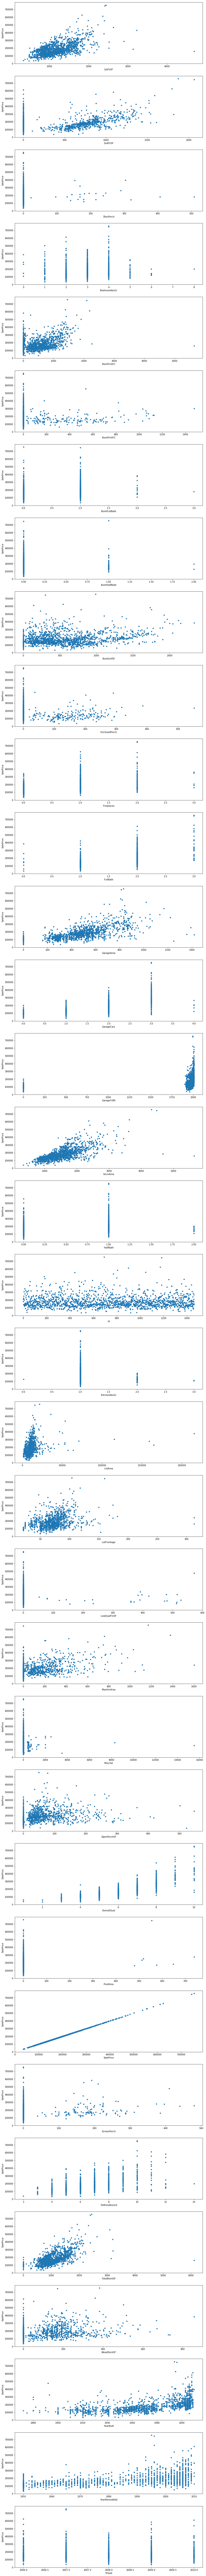

In [27]:
fig, axes = plt.subplots(figsize=(15,len(columns_numerical)*6), ncols=1, nrows=len(columns_numerical))
i = 0
for column in columns_numerical:
    data = pd.concat([train_df_absent_imputed_categorial['SalePrice'], train_df_absent_imputed_categorial[column]], axis=1)
    data.plot.scatter(x=column, y='SalePrice', ax = axes[i]);
    i += 1

### Skewness

Inspect wether logarithm might help.

In [28]:
def get_skewed_columns(df):
    for_inspection = pd.DataFrame()
    if "SalePrice" in df.columns:
        for_inspection["SalePrice"] = np.log1p(df["SalePrice"])

    #log transform skewed numeric features:
    numeric_feats = df.dtypes[df.dtypes != "object"].index
    
    skewed_feats = df[numeric_feats].apply(lambda x: skew(x)) #compute skewness
    skewed_feats = skewed_feats[skewed_feats > 0.75]
    skewed_feats = skewed_feats.index.tolist()
    skewed_feats = [column for column in skewed_feats if '_' not in column]
    return skewed_feats

In [29]:
skewed_feats = get_skewed_columns(train_df_absent_imputed_categorial)

In [30]:
def convert_numerical_skew(train_df, competition_df, skewed_feats):
    train_df_categorial = train_df.copy(deep=True)
    competition_df_categorial = competition_df.copy(deep=True)
    
    all_data = pd.concat((train_df_categorial, competition_df_categorial)).reset_index(drop=True)

    columns = get_skewed_columns(all_data)
    
    all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

    train_df_categorial = all_data[:train_df_categorial.shape[0]]
    competition_df_categorial = all_data[train_df_categorial.shape[0]:]
    competition_df_categorial = competition_df_categorial.drop(['SalePrice'], axis=1)
    return (train_df_categorial, competition_df_categorial)

In [31]:
(train_df_skew, competition_df_skew) = convert_numerical_skew(train_df_absent_imputed_categorial, competition_df_absent_imputed_categorial, skewed_feats)

### Add new column TotalSF

In [32]:
def get_correlation_totalsf(df):
    for_inspection = pd.DataFrame()
    if "SalePrice" in df.columns:
        for_inspection["SalePrice"] = df["SalePrice"]
    for_inspection['TotalBsmtSF'] = df['TotalBsmtSF']
    for_inspection['1stFlrSF'] = df['1stFlrSF']
    for_inspection['2ndFlrSF'] = df['2ndFlrSF']
    for_inspection['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
    return for_inspection.corr()

In [33]:
get_correlation_totalsf(train_df_absent_imputed_categorial)

,SalePrice,TotalBsmtSF,1stFlrSF,2ndFlrSF,TotalSF
SalePrice,1.000000,0.613581,0.605852,0.319334,0.782260
TotalBsmtSF,0.613581,1.000000,0.819530,-0.174512,0.826742
1stFlrSF,0.605852,0.819530,1.000000,-0.202646,0.800350
2ndFlrSF,0.319334,-0.174512,-0.202646,1.000000,0.342733
TotalSF,0.782260,0.826742,0.800350,0.342733,1.000000


In [34]:
def create_totalsf(train_df, competition_df):
    train_df_categorial = train_df.copy(deep=True)
    competition_df_categorial = competition_df.copy(deep=True)
    
    all_data = pd.concat((train_df_categorial, competition_df_categorial)).reset_index(drop=True)

    all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

    train_df_categorial = all_data[:train_df_categorial.shape[0]]
    competition_df_categorial = all_data[train_df_categorial.shape[0]:]
    competition_df_categorial = competition_df_categorial.drop(['SalePrice'], axis=1)
    return (train_df_categorial, competition_df_categorial)

In [35]:
(train_df_totalsf, competition_df_totalsf) = create_totalsf(train_df_absent_imputed_categorial, competition_df_absent_imputed_categorial)

### Clean zero values and transform them into boolean 

In [36]:
impute_zero_values_with_mean = [
    '2ndFlrSF',
    '3SsnPorch',
    'BsmtFinSF1',
    'BsmtFinSF2',
    'BsmtUnfSF',
    'EnclosedPorch',
    'GarageArea',
    'LowQualFinSF',
    'MasVnrArea',
    'MiscVal',
    'OpenPorchSF',
    'PoolArea',
    'ScreenPorch',
    'TotalBsmtSF',
    'WoodDeckSF',
    'YearRemodAdd',
]
impute_zero_values_with_mean_boolean = ['Has' + column for column in impute_zero_values_with_mean]

In [37]:
def transform_zero_values(train_df, competition_df, columns):
    train_df_transform = train_df.copy(deep=True)
    competition_df_transform = competition_df.copy(deep=True)
    
    all_data = pd.concat((train_df_transform, competition_df_transform)).reset_index(drop=True)

    for column in columns:
        all_data['Has' + column] = all_data[column].apply(lambda x: 1 if x > 0 else 0)
        
        mask = all_data[column] == 0
        all_data.loc[mask, column] = all_data[column].mean()

    train_df_transform = all_data[:train_df_transform.shape[0]]
    competition_df_transform = all_data[train_df_transform.shape[0]:]
    competition_df_transform = competition_df_transform.drop(['SalePrice'], axis=1)
    return (train_df_transform, competition_df_transform)

In [38]:
corr_before = train_df_absent_imputed_categorial[impute_zero_values_with_mean + ['SalePrice']].corr()['SalePrice']
(train_df_zero_values, competition_df_zero_values) = transform_zero_values(train_df_absent_imputed_categorial, competition_df_absent_imputed_categorial, impute_zero_values_with_mean)
corr_after = train_df_zero_values[impute_zero_values_with_mean + ['SalePrice']].corr()['SalePrice']

correlation_comparison = pd.concat([
    corr_before,
    corr_after
], axis=1)
correlation_comparison.columns = ['SP1', 'SP2']
correlation_comparison['comparison'] = -(abs(correlation_comparison['SP1'] - correlation_comparison['SP2'])/correlation_comparison['SP1'])*100
print(correlation_comparison.where(correlation_comparison['SP2'] > 0.5).dropna().sort_values(by='SP2', ascending=False))

                   SP1       SP2  comparison
SalePrice     1.000000  1.000000   -0.000000
TotalBsmtSF   0.613581  0.603425   -1.655205
GarageArea    0.623431  0.596212   -4.366025
YearRemodAdd  0.507101  0.507101   -0.000000


### Outlier Detection

In [39]:
def remove_outliers(train_df, competition_df):
    train_df_outlier = train_df.copy(deep=True)
    competition_df_outlier = competition_df.copy(deep=True)

    train_df_outlier.drop(train_df_outlier[(train_df_outlier['GrLivArea']>4000) & (train_df_outlier['SalePrice']<300000)].index, inplace=True)
    train_df_outlier.drop(train_df_outlier[(train_df_outlier['GarageArea']>1200) & (train_df_outlier['SalePrice']<300000)].index, inplace=True)
    train_df_outlier.drop(train_df_outlier[(train_df_outlier['TotalBsmtSF']>4000) & (train_df_outlier['SalePrice']<300000)].index, inplace=True)
    train_df_outlier.drop(train_df_outlier[(train_df_outlier['1stFlrSF']>4000) & (train_df_outlier['SalePrice']<300000)].index, inplace=True)
    train_df_outlier.drop(train_df_outlier[(train_df_outlier['BsmtFinSF1']>3000) & (train_df_outlier['SalePrice']<300000)].index, inplace=True)
    train_df_outlier.drop(train_df_outlier[(train_df_outlier['LotArea']>100000) & (train_df_outlier['SalePrice']<400000)].index, inplace=True)

    #competition_df_outlier.drop(competition_df_outlier[(competition_df_outlier['GrLivArea']>4000) & (competition_df_outlier['SalePrice']<300000)].index, inplace=True)
    #competition_df_outlier.drop(competition_df_outlier[(competition_df_outlier['GarageArea']>1200) & (competition_df_outlier['SalePrice']<300000)].index, inplace=True)
    #competition_df_outlier.drop(competition_df_outlier[(competition_df_outlier['TotalBsmtSF']>4000) & (competition_df_outlier['SalePrice']<300000)].index, inplace=True)
    #competition_df_outlier.drop(competition_df_outlier[(competition_df_outlier['1stFlrSF']>4000) & (competition_df_outlier['SalePrice']<300000)].index, inplace=True)
    #competition_df_outlier.drop(competition_df_outlier[(competition_df_outlier['BsmtFinSF1']>3000) & (competition_df_outlier['SalePrice']<300000)].index, inplace=True)
    #competition_df_outlier.drop(competition_df_outlier[(competition_df_outlier['LotArea']>100000) & (competition_df_outlier['SalePrice']<400000)].index, inplace=True)

    
    #train_df_outlier = train_df_outlier.dropna(how='all')
    #competition_df_outlier = competition_df_outlier.dropna(how='all')
    
    return (train_df_outlier, competition_df_outlier)

In [40]:
(train_df_outlier, competition_df_outlier) = remove_outliers(train_df_absent_imputed_categorial, competition_df_absent_imputed_categorial)

### Sum all senseful transformations

In [41]:
(train_df_numerical_all, competition_df_numerical_all) = convert_numerical_skew(train_df_absent_imputed_categorial, competition_df_absent_imputed_categorial, skewed_feats)
(train_df_numerical_all, competition_df_numerical_all) = create_totalsf(train_df_numerical_all, competition_df_numerical_all)
(train_df_numerical_all, competition_df_numerical_all) = transform_zero_values(train_df_numerical_all, competition_df_numerical_all, impute_zero_values_with_mean)

# Baseline Regressions

In [42]:
n_folds = 5

In [43]:
def evaluate_model(model, cv_X, cv_y):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(cv_X.values)
    rmse= np.sqrt(-cross_val_score(model, cv_X.values, cv_y.values, scoring="neg_mean_squared_error", cv = kf))
    return rmse

Compare to super-easy transformations by https://www.kaggle.com/apapiu/regularized-linear-models

In [44]:
def super_easy_transform(train_df, competition_df):
    
    train_df_1 = train_df.copy(deep=True)
    competition_df_1 = competition_df.copy(deep=True)

    combined_df_1 = pd.concat((train_df_1.loc[:,'MSSubClass':'SaleCondition'],
                          competition_df_1.loc[:,'MSSubClass':'SaleCondition']))

    #log transform skewed numeric features:
    numeric_feats = combined_df_1.dtypes[combined_df_1.dtypes != "object"].index

    skewed_feats = train_df[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
    skewed_feats = skewed_feats[skewed_feats > 0.75]
    skewed_feats = skewed_feats.index

    combined_df_1[skewed_feats] = np.log1p(combined_df_1[skewed_feats])
    combined_df_1 = pd.get_dummies(combined_df_1)
    combined_df_1 = combined_df_1.fillna(combined_df_1.mean())
    train_df_1 = combined_df_1[:train_df.shape[0]]
    competition_df_1 = combined_df_1[train_df.shape[0]:]
    train_df_1['SalePrice'] =  np.log1p(train_df['SalePrice'])
    
    return (train_df_1, competition_df_1)

In [45]:
(train_df_1, competition_df_1) = super_easy_transform(train_df, competition_df)

/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Compare with transformations of https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard

In [46]:
def notso_easy_transform(train_df, competition_df):
    train_df_2 = train_df.copy(deep=True)
    competition_df_2 = competition_df.copy(deep=True)
    
    ntrain = train_df_2.shape[0]
    ntest = competition_df_2.shape[0]
    y_train = train_df_2.SalePrice.values
    all_data = pd.concat((train_df_2, competition_df_2)).reset_index(drop=True)
    all_data.drop(['SalePrice'], axis=1, inplace=True)
    print("all_data size is : {}".format(all_data.shape))

    all_data["PoolQC"] = all_data["PoolQC"].fillna("None")
    all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")
    all_data["Alley"] = all_data["Alley"].fillna("None")
    all_data["Fence"] = all_data["Fence"].fillna("None")
    all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")
    all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
        lambda x: x.fillna(x.median()))
    for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
        all_data[col] = all_data[col].fillna('None')   
    for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
        all_data[col] = all_data[col].fillna(0)
    for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
        all_data[col] = all_data[col].fillna(0)
    for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
        all_data[col] = all_data[col].fillna('None')
    all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
    all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)
    all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])
    all_data = all_data.drop(['Utilities'], axis=1)
    all_data["Functional"] = all_data["Functional"].fillna("Typ")
    all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
    all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
    all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
    all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
    all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
    all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

    all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)
    all_data['OverallCond'] = all_data['OverallCond'].astype(str)
    all_data['YrSold'] = all_data['YrSold'].astype(str)
    all_data['MoSold'] = all_data['MoSold'].astype(str)

    from sklearn.preprocessing import LabelEncoder
    cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
            'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
            'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
            'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
            'YrSold', 'MoSold')
    for c in cols:
        lbl = LabelEncoder() 
        lbl.fit(list(all_data[c].values)) 
        all_data[c] = lbl.transform(list(all_data[c].values))
    print('Shape all_data: {}'.format(all_data.shape))
    all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

    numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
    skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
    skewness = pd.DataFrame({'Skew' :skewed_feats})
    skewness = skewness[abs(skewness) > 0.75]
    from scipy.special import boxcox1p
    skewed_features = skewness.index
    lam = 0.15
    for feat in skewed_features:
        #all_data[feat] += 1
        all_data[feat] = boxcox1p(all_data[feat], lam)

    all_data = pd.get_dummies(all_data)
    print(all_data.shape)

    train_df_2 = all_data[:ntrain]
    train_df_2['SalePrice'] =  np.log1p(train_df['SalePrice'])
    competition_df_2 = all_data[ntrain:]
    
    return (train_df_2, competition_df_2)

In [47]:
(train_df_2, competition_df_2) = notso_easy_transform(train_df, competition_df)

all_data size is : (2919, 80)
Shape all_data: (2919, 79)
(2919, 222)


/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [48]:
baseline_models = [
          #LinearRegression(), 
          make_pipeline(RobustScaler(), Ridge(random_state=0)),
          make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1)),
          make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3)),
          #SGDRegressor(random_state=0, max_iter = 10000, tol =0.001),
          make_pipeline(RobustScaler(), KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)),
          make_pipeline(RobustScaler(), SVR(C=1.0, epsilon=0.2)),
          make_pipeline(RobustScaler(), LinearSVR(random_state=0)),
          make_pipeline(RobustScaler(), RandomForestRegressor(random_state=0)),
          make_pipeline(RobustScaler(), KNeighborsRegressor()),
          make_pipeline(RobustScaler(), GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =0)),
          make_pipeline(RobustScaler(), AdaBoostRegressor(random_state =0))
         ]

In [49]:
def prepare_datasets(datasets):
    prepare_datasets = {}
    for dataset_name in datasets:
        print(dataset_name)
        train_df = datasets[dataset_name]['dataset'].copy(deep=True)
        train_X = train_df
        train_y = train_df['SalePrice'].copy()
        train_X = train_X.drop(['SalePrice'], axis=1)

        train_X, evaluate_X, train_y, evaluate_y = train_test_split(train_X, train_y, random_state=0)
        train_X, test_X, train_y, test_y = train_test_split(train_X, train_y, random_state=0)
        
        print('\ttrain_X', train_X.shape, train_y.shape)
        print('\ttest_X', test_X.shape, test_y.shape)
        print('\tevaluate_X', evaluate_X.shape, evaluate_y.shape)
        prepare_datasets[dataset_name] = {
            'train_X': train_X, 
            'train_y': train_y, 
            'test_X': test_X, 
            'test_y': test_y, 
            'evaluate_X': evaluate_X, 
            'evaluate_y': evaluate_y,
            'log': datasets[dataset_name]['log']
        }
    return prepare_datasets

In [50]:
datasets = {
        #'01.1 train_df_imputed numerical only': {'dataset': train_df_imputed[train_df_imputed.describe().columns], 'log': False, 'ops': ['imputed missing values individually']},
        #'01.2 train_df_absent_imputed numerical only': {'dataset': train_df_absent_imputed[train_df_absent_imputed.describe().columns], 'log': False, 'ops': ['dropped absent features', 'imputed missing values individually']},
        #'01.3 train_df_imputed_categorial': {'dataset': train_df_imputed_categorial, 'log': False, 'ops': ['imputed missing values individually', 'convert categorial to dummies']},
        '01.4 train_df_absent_imputed_categorial': {'dataset': train_df_absent_imputed_categorial, 'log': False, 'ops': ['dropped absent features', 'imputed missing values individually', 'convert categorial to dummies']},
        '02.1 train_df_skew': {'dataset': train_df_skew, 'log': True, 'ops': ['dropped absent features', 'imputed missing values individually', 'convert categorial to dummies', 'skewness removed']},
        '02.2 train_df_totalsf': {'dataset': train_df_totalsf, 'log': False, 'ops': ['dropped absent features', 'imputed missing values individually', 'convert categorial to dummies', 'added feature totalsf']},
        '02.3 train_df_zero_values': {'dataset': train_df_zero_values, 'log': False, 'ops': ['dropped absent features', 'imputed missing values individually', 'convert categorial to dummies', 'transformed zero values']},
        #'02.4 train_df_outlier': {'dataset': train_df_outlier, 'log': False, 'ops': ['dropped absent features', 'imputed missing values individually', 'convert categorial to dummies', 'remove outliers']},
        '02.5 train_df_numerical_all': {'dataset': train_df_numerical_all, 'log': True, 'ops': ['dropped absent features', 'imputed missing values individually', 'convert categorial to dummies', 'skewness removed', 'added feature totalsf', 'transformed zero values']},

        '03.1 train_df_1': {'dataset': train_df_1, 'log': True, 'ops': ['easy transformations']},
        '03.2 train_df_2': {'dataset': train_df_2, 'log': True, 'ops': ['not soeasy transformations']},
    }

In [51]:
prepared_datasets = prepare_datasets(datasets)

02.1 train_df_skew
	train_X (821, 314) (821,)
	test_X (274, 314) (274,)
	evaluate_X (365, 314) (365,)
02.2 train_df_totalsf
	train_X (821, 315) (821,)
	test_X (274, 315) (274,)
	evaluate_X (365, 315) (365,)
02.3 train_df_zero_values
	train_X (821, 330) (821,)
	test_X (274, 330) (274,)
	evaluate_X (365, 330) (365,)
03.1 train_df_1
	train_X (821, 322) (821,)
	test_X (274, 322) (274,)
	evaluate_X (365, 322) (365,)
01.4 train_df_absent_imputed_categorial
	train_X (821, 314) (821,)
	test_X (274, 314) (274,)
	evaluate_X (365, 314) (365,)
02.5 train_df_numerical_all
	train_X (821, 331) (821,)
	test_X (274, 331) (274,)
	evaluate_X (365, 331) (365,)
03.2 train_df_2
	train_X (821, 222) (821,)
	test_X (274, 222) (274,)
	evaluate_X (365, 222) (365,)


In [52]:
def process_datasets_with_models(datasets, models):
    baselines = pd.DataFrame(columns=['model', 'dataset', 'values'])
    for model in models:
        name = type(model).__name__
        if name == 'Pipeline':
            name = str([step for step in model.named_steps])
        print('Model:', name)
        for dataset_name in datasets:
            print('\tDataset', dataset_name)
            tmp_X = datasets[dataset_name]['train_X'].copy(deep=True)
            tmp_y = datasets[dataset_name]['train_y'].copy(deep=True)
            baseline = {}
            baseline['model'] = name
            baseline['dataset'] = dataset_name
            baseline['rmse_train'] = evaluate_model(model, tmp_X, tmp_y)
            model.fit(tmp_X, tmp_y)
            pred = model.predict(datasets[dataset_name]['test_X'].copy(deep=True))
            real = datasets[dataset_name]['test_y'].copy(deep=True)
            if datasets[dataset_name]['log']:
                pred = np.expm1(pred)
                real = np.expm1(real)
            baseline['rmse_test'] = np.sqrt(mean_squared_error(real, pred))
            baselines = baselines.append(baseline, ignore_index=True)
    return baselines

In [53]:
baselines = process_datasets_with_models(prepared_datasets, baseline_models)

Model: ['robustscaler', 'ridge']
	Dataset 02.1 train_df_skew
	Dataset 02.2 train_df_totalsf
	Dataset 02.5 train_df_numerical_all
	Dataset 03.1 train_df_1
	Dataset 01.4 train_df_absent_imputed_categorial
	Dataset 02.3 train_df_zero_values
	Dataset 03.2 train_df_2
Model: ['robustscaler', 'lasso']
	Dataset 02.1 train_df_skew
	Dataset 02.2 train_df_totalsf


/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_desc

	Dataset 02.5 train_df_numerical_all
	Dataset 03.1 train_df_1
	Dataset 01.4 train_df_absent_imputed_categorial


/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_desc

	Dataset 02.3 train_df_zero_values


/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_desc

	Dataset 03.2 train_df_2
Model: ['robustscaler', 'elasticnet']
	Dataset 02.1 train_df_skew
	Dataset 02.2 train_df_totalsf


/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_desc

	Dataset 02.5 train_df_numerical_all
	Dataset 03.1 train_df_1
	Dataset 01.4 train_df_absent_imputed_categorial


/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_desc

	Dataset 02.3 train_df_zero_values


/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_desc

	Dataset 03.2 train_df_2
Model: ['kernelridge', 'robustscaler']
	Dataset 02.1 train_df_skew
	Dataset 02.2 train_df_totalsf
	Dataset 02.5 train_df_numerical_all
	Dataset 03.1 train_df_1
	Dataset 01.4 train_df_absent_imputed_categorial
	Dataset 02.3 train_df_zero_values
	Dataset 03.2 train_df_2
Model: ['svr', 'robustscaler']
	Dataset 02.1 train_df_skew
	Dataset 02.2 train_df_totalsf
	Dataset 02.5 train_df_numerical_all
	Dataset 03.1 train_df_1
	Dataset 01.4 train_df_absent_imputed_categorial
	Dataset 02.3 train_df_zero_values
	Dataset 03.2 train_df_2
Model: ['linearsvr', 'robustscaler']
	Dataset 02.1 train_df_skew
	Dataset 02.2 train_df_totalsf
	Dataset 02.5 train_df_numerical_all
	Dataset 03.1 train_df_1
	Dataset 01.4 train_df_absent_imputed_categorial
	Dataset 02.3 train_df_zero_values
	Dataset 03.2 train_df_2
Model: ['robustscaler', 'randomforestregressor']
	Dataset 02.1 train_df_skew
	Dataset 02.2 train_df_totalsf
	Dataset 02.5 train_df_numerical_all
	Dataset 03.1 train_df_1
	Dataset

In [54]:
baselines.groupby(['model', 'dataset']).mean().sort_values('rmse_test', ascending=True).head(10)

,,rmse_test
model,dataset,
"['robustscaler', 'ridge']",02.5 train_df_numerical_all,21924.564138
"['robustscaler', 'elasticnet']",02.5 train_df_numerical_all,22663.186249
"['robustscaler', 'ridge']",02.1 train_df_skew,22728.191738
"['robustscaler', 'lasso']",02.5 train_df_numerical_all,22735.543476
"['robustscaler', 'ridge']",03.1 train_df_1,23069.468181
"['robustscaler', 'elasticnet']",02.1 train_df_skew,23187.807765
"['robustscaler', 'lasso']",02.1 train_df_skew,23261.558774
"['robustscaler', 'elasticnet']",03.1 train_df_1,23278.738548
"['robustscaler', 'lasso']",03.1 train_df_1,23338.450991


(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

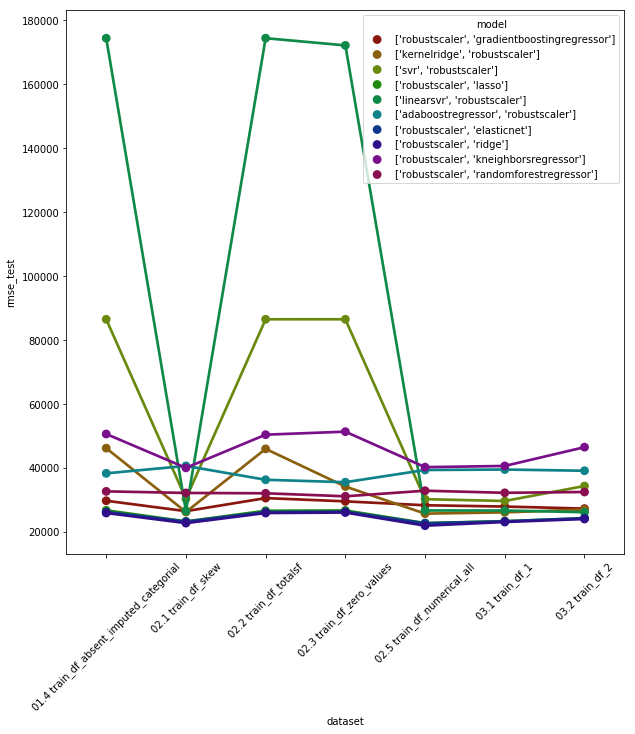

In [55]:
baselines = baselines.sort_values(['dataset'])
fig, ax = plt.subplots(figsize=(10, 10))
sns.pointplot(y="rmse_test", x="dataset", hue="model", data=baselines, ax=ax, palette=sns.hls_palette(10, l=.3, s=.8) )
plt.xticks(rotation=45)

In [56]:
best_simple_models = baselines[baselines['dataset'] == '02.5 train_df_numerical_all'].sort_values(['rmse_test'])['model'].head()
best_simple_models

2           ['robustscaler', 'ridge']
16     ['robustscaler', 'elasticnet']
9           ['robustscaler', 'lasso']
23    ['kernelridge', 'robustscaler']
37      ['linearsvr', 'robustscaler']
Name: model, dtype: object

In [57]:
best_dataset = prepared_datasets['02.5 train_df_numerical_all']

In [58]:
#best_baseline_model = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
#best_baseline_model.fit(train_X, train_y)
#print(best_baseline_model.score(train_X, train_y))
#print(best_baseline_model.score(test_X, test_y))
#print(best_baseline_model.score(evaluate_X, evaluate_y))
#pred_y = best_baseline_model.predict( competition_X )
#id = competition_X.Id
#prediction = pd.DataFrame( { 'Id': id , 'SalePrice': pred_y } )
#prediction.SalePrice = np.expm1(prediction.SalePrice.astype(float))
#prediction.shape
#print(prediction.head())
#prediction.to_csv( 'houseprice_prediction.csv' , index = False )

# Regressions

In [59]:
fits = {}
models = {}
scores = {}
evaluation = {}
feature_selections = {}
rmse_test = {}

cache_dirs = []

In [60]:
scorings = "neg_mean_squared_error"
n_folds = 5

grid_search_parameters = {
    'scoring': scorings, 
    'n_jobs': 1, 
    'verbose': 1, 
    'refit': True,
    'return_train_score': True,
    'error_score': 0
}

In [61]:
def build_pipelline(base_model, pipeline, param_grid, reduce_dim_param_grid, grid_search_parameters, cache_dirs):
    if param_grid != None:
        param_grid = [{'classify__'+key: value for (key, value) in inner_param_grid.items()} for inner_param_grid in param_grid]
        if type(param_grid) == list:
            for i in range(len(param_grid)):
                for key, value in reduce_dim_param_grid.items():
                    param_grid[i][key] = value
        if type(param_grid) == dict:
            for key, value in reduce_dim_param_grid.items():
                param_grid[key] = value
    cachedir = mkdtemp()
    cache_dirs.append(cachedir)
    memory = Memory(cachedir=cachedir, verbose=0)
    pipe = Pipeline(pipeline, memory=memory)
    #pipe = Pipeline(pipeline)
    if param_grid == None:
        return pipe
    else:
        gridsearch = GridSearchCV(
            pipe, 
            param_grid = param_grid, 
            **grid_search_parameters
        )
        return gridsearch

def build_experiments(model_name, base_model, param_grid, grid_search_parameters, cache_dirs):
    
    reduce_dims = [
        None,
        SelectKBest(f_regression),
        SelectPercentile(f_regression),
        SelectFromModel(Ridge())
    ]
    
    scalers = [
        None,
        StandardScaler(),
        #MinMaxScaler(),
        RobustScaler(quantile_range=(25, 75)),
        #Normalizer()
    ]
    
    experiments = []
    
    for reduce_dim in reduce_dims:
        for scaler in scalers:
            experiment_name = model_name
            pipeline = []            
            if reduce_dim != None:
                pipeline.append(('reduce_dim', reduce_dim))
                experiment_name += "-" + type(reduce_dim).__name__
            if scaler != None:
                pipeline.append(('scaler', scaler))
                experiment_name += "-" + type(scaler).__name__
            pipeline.append(('VarianceThreshold', VarianceThreshold()))
            pipeline.append(('classify', clone(base_model)))
            experiment = build_pipelline(
                base_model, 
                pipeline , 
                param_grid, 
                {}, 
                grid_search_parameters, 
                cache_dirs
            )
            experiments.append((experiment_name, experiment))
    
    return experiments

In [62]:
def clean_cache_dirs(cache_dirs):
    for cache_dir in cache_dirs:
        if os.path.exists(cache_dir):
            rmtree(cache_dir)
    cache_dirs = []

In [74]:
def run_experiments(train_X , train_y, evaluate_X, evaluate_y, experiments, models, evaluation, feature_selections, scores, cache_dirs, rmse_test):
    for (model_name, model) in experiments:
        print('Fit', model_name)
        model.fit(train_X , train_y)

        print('model', type(model).__name__)
        if type(model).__name__ == 'GridSearchCV':
            best_model = model.best_estimator_
            print(type(best_model))
            if False and type(best_model).__name__ == 'Pipeline':
                if 'reduce_dim' in best_model.named_steps:
                    reduce_dim = best_model.named_steps['reduce_dim']
                    selected_features = print_features(reduce_dim)
                    feature_selections[model_name] = [
                        selected_features,
                        model.best_score_
                    ]
        else:
            best_model = model
        
        print('best_model', type(best_model).__name__)

        models[model_name] = {}
        models[model_name] = best_model

        evaluation[model_name] = evaluate_model(best_model, evaluate_X, evaluate_y)
        scores[model_name] = (best_model.score(train_X, train_y), best_model.score(evaluate_X, evaluate_y))
        
        best_model_fit = clone(best_model).fit(train_X, train_y)
        pred = best_model_fit.predict(evaluate_X.copy(deep=True))
        real = evaluate_y.copy(deep=True)
        #if datasets[dataset_name]['log']:
        #    pred = np.expm1(pred)
        #    real = np.expm1(real)
        rmse_test[model_name] = np.sqrt(mean_squared_error(real, pred))
    clean_cache_dirs(cache_dirs)

In [64]:
def print_features(reduce_dim):
    print('print_features')
    if type(reduce_dim).__name__ == 'SelectKBest':
        feature_scores = ['%.2f' % elem for elem in reduce_dim.scores_ ]
    else:
        feature_scores = np.zeros(len(train_X.columns))

    features_selected_tuple=[(train_X.columns[i], feature_scores[i]) for i in reduce_dim.get_support(indices=True)]
    features_selected_tuple = sorted(features_selected_tuple, key=lambda feature: float(feature[1]) , reverse=True)

    print(features_selected_tuple)
    return features_selected_tuple

In [65]:
def show_group_evaluation(evaluation, model_group, limit=5, max_per_group=False):
    evaluation_stats = []
    for model in evaluation:
        if model.startswith(model_group):
            evaluation_stat = {}
            evaluation_stat['group'] = model.split('-')[0]
            evaluation_stat['type'] = model    
            for sample in ['test', 'train']:#['train', 'test']:
                evaluation_stat[sample + '_mean'] = np.array(evaluation[model]).mean()
                evaluation_stat[sample + '_std'] = np.array(evaluation[model]).std()
            evaluation_stats.append(evaluation_stat)
    evaluation_stats = pd.DataFrame(evaluation_stats)
    evaluation_stats_sorted = evaluation_stats.sort_values(['test_mean', 'test_std'], ascending=[True, True])
    if max_per_group:
        evaluation_stats_sorted = evaluation_stats_sorted.groupby('group', as_index=False).first()
        evaluation_stats_sorted = evaluation_stats_sorted.sort_values(['test_mean', 'test_std'], ascending=[True, True])
    ICD.display(evaluation_stats_sorted[['group', 'type', 'test_mean', 'test_std', 'train_mean', 'train_std']].head(limit))

In [66]:
def show_scores(scores, model_name, limit=5):
    tmp = []
    for model in scores:
        if model.startswith(model_name):
            tmp.append([model, scores[model][0], scores[model][1]])
    tmp = pd.DataFrame(tmp)
    tmp.columns = ['model_name', 'train', 'test']
    tmp_sorted = tmp.sort_values(['test'], ascending=[False])
    ICD.display(tmp_sorted.head(limit))

In [67]:
def plot_predictions(models, model_name, model_filter=(), limit=5):
    for model in models:
        if model.startswith(model_name) and model.startswith(model_filter):
            test_pre = models[model].predict(evaluate_X)
            train_pre = models[model].predict(train_X)
            f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(15,5))
            plt.title(model)
            ax1.scatter(train_pre, train_pre - train_y, c = "blue",  label = "Training data")
            ax1.scatter(test_pre,test_pre - evaluate_y, c = "black",  label = "Validation data")
            ax1.set_title("Prediction vs Residuals")
            ax1.set_xlabel("Predicted values")
            ax1.set_ylabel("Residuals")
            ax1.legend(loc = "upper left")
            ax1.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
            # Plot predictions - Real values
            ax2.scatter(train_pre, train_y, c = "blue",  label = "Training data")
            ax2.scatter(test_pre, evaluate_y, c = "black",  label = "Validation data")
            ax2.set_title("Prediction vs Real")
            ax2.set_xlabel("Predicted values")
            ax2.set_ylabel("Real values")
            ax2.legend(loc = "upper left")
            ax2.plot([10.5, 13.5], [10.5, 13.5], c = "red")
            plt.suptitle(model)
            plt.show()

## RidgeRegression

In [75]:
model_name = 'Ridge'
base_model = Ridge(random_state=0)

param_grid = [
    {
        #'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
        'alpha': [0.1, 1.0, 10.0]
    }
]

experiments = build_experiments(model_name, base_model, param_grid, grid_search_parameters, cache_dirs)
run_experiments(best_dataset['train_X'] , best_dataset['train_y'], best_dataset['evaluate_X'], best_dataset['evaluate_y'], experiments, models, evaluation, feature_selections, scores, cache_dirs, rmse_test)

Fit Ridge
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.3s finished


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
best_model Pipeline
Fit Ridge-StandardScaler
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.3s finished


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
best_model Pipeline
Fit Ridge-RobustScaler
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.3s finished


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
best_model Pipeline
Fit Ridge-SelectKBest
Fitting 3 folds for each of 3 candidates, totalling 9 fits


/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:303: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x <

model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
best_model Pipeline
Fit Ridge-SelectKBest-StandardScaler
Fitting 3 folds for each of 3 candidates, totalling 9 fits


/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:303: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x <

model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
best_model Pipeline
Fit Ridge-SelectKBest-RobustScaler
Fitting 3 folds for each of 3 candidates, totalling 9 fits


/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:303: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x <

model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
best_model Pipeline
Fit Ridge-SelectPercentile
Fitting 3 folds for each of 3 candidates, totalling 9 fits


/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:303: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x <

model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
best_model Pipeline
Fit Ridge-SelectPercentile-StandardScaler
Fitting 3 folds for each of 3 candidates, totalling 9 fits


/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:303: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x <

model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
best_model Pipeline
Fit Ridge-SelectPercentile-RobustScaler
Fitting 3 folds for each of 3 candidates, totalling 9 fits


/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:303: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x <

model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
best_model Pipeline
Fit Ridge-SelectFromModel
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.3s finished


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
best_model Pipeline
Fit Ridge-SelectFromModel-StandardScaler
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.3s finished


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
best_model Pipeline
Fit Ridge-SelectFromModel-RobustScaler
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.3s finished


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
best_model Pipeline


In [76]:
show_group_evaluation(evaluation, model_name)

,group,type,test_mean,test_std,train_mean,train_std
5,Ridge,Ridge-SelectPercentile-RobustScaler,0.157296,0.042188,0.157296,0.042188
7,Ridge,Ridge-SelectPercentile-StandardScaler,0.160000,0.041571,0.160000,0.041571
6,Ridge,Ridge-SelectPercentile,0.161249,0.041088,0.161249,0.041088
9,Ridge,Ridge-SelectKBest-StandardScaler,0.164516,0.039917,0.164516,0.039917
1,Ridge,Ridge-SelectKBest-RobustScaler,0.164768,0.040361,0.164768,0.040361


In [77]:
show_scores(scores, model_name)

,model_name,train,test
4,Ridge-RobustScaler,0.937057,0.858138
10,Ridge,0.936182,0.855546
0,Ridge-SelectFromModel-RobustScaler,0.904925,0.834891
5,Ridge-SelectPercentile-RobustScaler,0.870237,0.825778
7,Ridge-SelectPercentile-StandardScaler,0.870942,0.825125


In [ ]:
#plot_predictions(models, model_name, ("Ridge-SelectPercentile-RobustScaler", "Ridge-RobustScaler"))

## LassoRegression

In [78]:
model_name = 'Lasso'
base_model = Lasso(random_state=0, positive=True)

param_grid = [
    {
        'alpha': [0.01, 0.1, 1.0, 10.0]
    }
]

experiments = build_experiments(model_name, base_model, param_grid, grid_search_parameters, cache_dirs)
run_experiments(best_dataset['train_X'] , best_dataset['train_y'], best_dataset['evaluate_X'], best_dataset['evaluate_y'], experiments, models, evaluation, feature_selections, scores, cache_dirs, rmse_test)

Fit Lasso
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.3s finished


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
best_model Pipeline
Fit Lasso-StandardScaler
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.4s finished


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
best_model Pipeline
Fit Lasso-RobustScaler
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.4s finished


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
best_model Pipeline
Fit Lasso-SelectKBest
Fitting 3 folds for each of 4 candidates, totalling 12 fits


/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:303: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x <

model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
best_model Pipeline
Fit Lasso-SelectKBest-StandardScaler
Fitting 3 folds for each of 4 candidates, totalling 12 fits


/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:303: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x <

model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
best_model Pipeline
Fit Lasso-SelectKBest-RobustScaler
Fitting 3 folds for each of 4 candidates, totalling 12 fits


/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:303: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x <

model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
best_model Pipeline
Fit Lasso-SelectPercentile
Fitting 3 folds for each of 4 candidates, totalling 12 fits


/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:303: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x <

model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
best_model Pipeline
Fit Lasso-SelectPercentile-StandardScaler
Fitting 3 folds for each of 4 candidates, totalling 12 fits


/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:303: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x <

model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
best_model Pipeline
Fit Lasso-SelectPercentile-RobustScaler
Fitting 3 folds for each of 4 candidates, totalling 12 fits


/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:303: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x <

model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
best_model Pipeline
Fit Lasso-SelectFromModel
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.3s finished


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
best_model Pipeline
Fit Lasso-SelectFromModel-StandardScaler
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.4s finished


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
best_model Pipeline
Fit Lasso-SelectFromModel-RobustScaler
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.4s finished


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
best_model Pipeline


In [79]:
show_group_evaluation(evaluation, model_name)

,group,type,test_mean,test_std,train_mean,train_std
2,Lasso,Lasso-SelectPercentile-StandardScaler,0.156428,0.038900,0.156428,0.038900
0,Lasso,Lasso-RobustScaler,0.159951,0.039181,0.159951,0.039181
3,Lasso,Lasso-SelectPercentile-RobustScaler,0.160482,0.038317,0.160482,0.038317
10,Lasso,Lasso-StandardScaler,0.163331,0.043200,0.163331,0.043200
8,Lasso,Lasso-SelectKBest-StandardScaler,0.165693,0.038584,0.165693,0.038584


In [80]:
show_scores(scores, model_name)

,model_name,train,test
10,Lasso-StandardScaler,0.898331,0.856599
2,Lasso-SelectPercentile-StandardScaler,0.865801,0.834438
3,Lasso-SelectPercentile-RobustScaler,0.856730,0.832459
0,Lasso-RobustScaler,0.867261,0.829866
5,Lasso-SelectKBest-RobustScaler,0.830376,0.821171


In [ ]:
#plot_predictions(models, model_name, ("Ridge-SelectPercentile",))

## ElasticNet

In [81]:
model_name = 'ElasticNet'
base_model = ElasticNet(random_state=0, positive=True)

param_grid = [
    {
        'alpha': [0.01, 0.1, 1.0, 10.0]
    }
]

experiments = build_experiments(model_name, base_model, param_grid, grid_search_parameters, cache_dirs)
run_experiments(best_dataset['train_X'] , best_dataset['train_y'], best_dataset['evaluate_X'], best_dataset['evaluate_y'], experiments, models, evaluation, feature_selections, scores, cache_dirs, rmse_test)

Fit ElasticNet
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.3s finished


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
best_model Pipeline
Fit ElasticNet-StandardScaler
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.4s finished


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
best_model Pipeline
Fit ElasticNet-RobustScaler
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.4s finished


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
best_model Pipeline
Fit ElasticNet-SelectKBest
Fitting 3 folds for each of 4 candidates, totalling 12 fits


/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:303: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x <

model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
best_model Pipeline
Fit ElasticNet-SelectKBest-StandardScaler
Fitting 3 folds for each of 4 candidates, totalling 12 fits


/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:303: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x <

model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
best_model Pipeline
Fit ElasticNet-SelectKBest-RobustScaler
Fitting 3 folds for each of 4 candidates, totalling 12 fits


/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:303: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x <

model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
best_model Pipeline
Fit ElasticNet-SelectPercentile
Fitting 3 folds for each of 4 candidates, totalling 12 fits


/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:303: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x <

model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
best_model Pipeline
Fit ElasticNet-SelectPercentile-StandardScaler
Fitting 3 folds for each of 4 candidates, totalling 12 fits


/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:303: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x <

model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
best_model Pipeline
Fit ElasticNet-SelectPercentile-RobustScaler
Fitting 3 folds for each of 4 candidates, totalling 12 fits


/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:303: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x <

model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
best_model Pipeline
Fit ElasticNet-SelectFromModel
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.3s finished


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
best_model Pipeline
Fit ElasticNet-SelectFromModel-StandardScaler
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.4s finished


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
best_model Pipeline
Fit ElasticNet-SelectFromModel-RobustScaler
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.4s finished


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
best_model Pipeline


In [82]:
show_group_evaluation(evaluation, model_name)

,group,type,test_mean,test_std,train_mean,train_std
3,ElasticNet,ElasticNet-SelectPercentile-StandardScaler,0.155544,0.040595,0.155544,0.040595
1,ElasticNet,ElasticNet-SelectPercentile-RobustScaler,0.157714,0.040672,0.157714,0.040672
0,ElasticNet,ElasticNet-RobustScaler,0.159445,0.041872,0.159445,0.041872
7,ElasticNet,ElasticNet-SelectPercentile,0.163106,0.037628,0.163106,0.037628
8,ElasticNet,ElasticNet-StandardScaler,0.164394,0.049264,0.164394,0.049264


In [83]:
show_scores(scores, model_name)

,model_name,train,test
8,ElasticNet-StandardScaler,0.917724,0.853330
0,ElasticNet-RobustScaler,0.879270,0.834969
3,ElasticNet-SelectPercentile-StandardScaler,0.867988,0.831364
1,ElasticNet-SelectPercentile-RobustScaler,0.861998,0.829968
6,ElasticNet,0.872664,0.827286


# KernelRidge

In [84]:
model_name = 'KernelRidge'
base_model = KernelRidge()

param_grid = [
    {
        'alpha': [0.1, 1.0, 10.0]
    }
]

experiments = build_experiments(model_name, base_model, param_grid, grid_search_parameters, cache_dirs)
run_experiments(best_dataset['train_X'] , best_dataset['train_y'], best_dataset['evaluate_X'], best_dataset['evaluate_y'], experiments, models, evaluation, feature_selections, scores, cache_dirs, rmse_test)

Fit KernelRidge
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.4s finished


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
best_model Pipeline
Fit KernelRidge-StandardScaler
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.4s finished


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
best_model Pipeline
Fit KernelRidge-RobustScaler
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.5s finished


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
best_model Pipeline
Fit KernelRidge-SelectKBest
Fitting 3 folds for each of 3 candidates, totalling 9 fits


/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:303: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x <

model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
best_model Pipeline
Fit KernelRidge-SelectKBest-StandardScaler
Fitting 3 folds for each of 3 candidates, totalling 9 fits


/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:303: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x <

model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
best_model Pipeline
Fit KernelRidge-SelectKBest-RobustScaler
Fitting 3 folds for each of 3 candidates, totalling 9 fits


/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:303: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x <

model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
best_model Pipeline


/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:303: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x <

Fit KernelRidge-SelectPercentile
Fitting 3 folds for each of 3 candidates, totalling 9 fits


/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:303: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x <

model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
best_model Pipeline
Fit KernelRidge-SelectPercentile-StandardScaler
Fitting 3 folds for each of 3 candidates, totalling 9 fits


/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:303: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x <

model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
best_model Pipeline


/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:303: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x <

Fit KernelRidge-SelectPercentile-RobustScaler
Fitting 3 folds for each of 3 candidates, totalling 9 fits


/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:303: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x <

model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
best_model Pipeline
Fit KernelRidge-SelectFromModel
Fitting 3 folds for each of 3 candidates, totalling 9 fits


/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:303: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x <

model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
best_model Pipeline
Fit KernelRidge-SelectFromModel-StandardScaler
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.4s finished


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
best_model Pipeline
Fit KernelRidge-SelectFromModel-RobustScaler
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.5s finished


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
best_model Pipeline


In [85]:
show_group_evaluation(evaluation, model_name)

,group,type,test_mean,test_std,train_mean,train_std
2,KernelRidge,KernelRidge-SelectPercentile,0.161519,0.042427,0.161519,0.042427
11,KernelRidge,KernelRidge-SelectKBest,0.166594,0.043414,0.166594,0.043414
9,KernelRidge,KernelRidge,0.172082,0.045826,0.172082,0.045826
1,KernelRidge,KernelRidge-SelectFromModel,0.248355,0.071858,0.248355,0.071858
8,KernelRidge,KernelRidge-RobustScaler,0.306815,0.049309,0.306815,0.049309


In [86]:
show_scores(scores, model_name)

,model_name,train,test
9,KernelRidge,0.936049,0.854412
2,KernelRidge-SelectPercentile,0.871004,0.825150
11,KernelRidge-SelectKBest,0.833966,0.815023
8,KernelRidge-RobustScaler,0.957978,0.751462
1,KernelRidge-SelectFromModel,0.920667,0.648743


# GradientBoostingRegressor

In [87]:
model_name = 'GradientBoostingRegressor'
base_model = GradientBoostingRegressor(random_state =0)

param_grid = [
    {
        'n_estimators': [10, 100, 1000],
        'learning_rate' : [0.01, 0.05, 0.1],
        #'loss' : ['huber', 'ls'],
        #'min_samples_split': [2, 10],
        #'min_samples_leaf': [1, 10, 15],
        #'max_depth': [3, 4, 5],
        #'max_features': [None, 'sqrt'],
    }
]

experiments = build_experiments(model_name, base_model, param_grid, grid_search_parameters, cache_dirs)
run_experiments(best_dataset['train_X'] , best_dataset['train_y'], best_dataset['evaluate_X'], best_dataset['evaluate_y'], experiments, models, evaluation, feature_selections, scores, cache_dirs, rmse_test)

Fit GradientBoostingRegressor
Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:   32.5s finished


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
best_model Pipeline
Fit GradientBoostingRegressor-StandardScaler
Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:   31.7s finished


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
best_model Pipeline
Fit GradientBoostingRegressor-RobustScaler
Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:   31.5s finished


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
best_model Pipeline
Fit GradientBoostingRegressor-SelectKBest
Fitting 3 folds for each of 9 candidates, totalling 27 fits


/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:303: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x <

model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
best_model Pipeline


/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:303: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x <

Fit GradientBoostingRegressor-SelectKBest-StandardScaler
Fitting 3 folds for each of 9 candidates, totalling 27 fits


/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:303: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x <

model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
best_model Pipeline


/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:303: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x <

Fit GradientBoostingRegressor-SelectKBest-RobustScaler
Fitting 3 folds for each of 9 candidates, totalling 27 fits


/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:303: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x <

model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
best_model Pipeline


/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:303: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x <

Fit GradientBoostingRegressor-SelectPercentile
Fitting 3 folds for each of 9 candidates, totalling 27 fits


/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:303: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x <

model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
best_model Pipeline


/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:303: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x <

Fit GradientBoostingRegressor-SelectPercentile-StandardScaler
Fitting 3 folds for each of 9 candidates, totalling 27 fits


/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:303: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x <

model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
best_model Pipeline


/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:303: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x <

Fit GradientBoostingRegressor-SelectPercentile-RobustScaler
Fitting 3 folds for each of 9 candidates, totalling 27 fits


/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:303: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x <

model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
best_model Pipeline


/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:303: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x <

Fit GradientBoostingRegressor-SelectFromModel
Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:   12.6s finished


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
best_model Pipeline
Fit GradientBoostingRegressor-SelectFromModel-StandardScaler
Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:   12.7s finished


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
best_model Pipeline
Fit GradientBoostingRegressor-SelectFromModel-RobustScaler
Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:   12.6s finished


model GridSearchCV
<class 'sklearn.pipeline.Pipeline'>
best_model Pipeline


In [88]:
show_group_evaluation(evaluation, model_name)

,group,type,test_mean,test_std,train_mean,train_std
1,GradientBoostingRegressor,GradientBoostingRegressor,0.154946,0.036503,0.154946,0.036503
4,GradientBoostingRegressor,GradientBoostingRegressor-RobustScaler,0.154952,0.036515,0.154952,0.036515
10,GradientBoostingRegressor,GradientBoostingRegressor-StandardScaler,0.154954,0.036511,0.154954,0.036511
5,GradientBoostingRegressor,GradientBoostingRegressor-SelectFromModel,0.166047,0.023269,0.166047,0.023269
6,GradientBoostingRegressor,GradientBoostingRegressor-SelectFromModel-Robu...,0.166047,0.023269,0.166047,0.023269


In [89]:
show_scores(scores, model_name)

,model_name,train,test
10,GradientBoostingRegressor-StandardScaler,0.995333,0.890865
1,GradientBoostingRegressor,0.995333,0.890680
4,GradientBoostingRegressor-RobustScaler,0.995333,0.890436
9,GradientBoostingRegressor-SelectPercentile-Sta...,0.948165,0.862566
7,GradientBoostingRegressor-SelectPercentile,0.948165,0.862558


# Evaluation

In [ ]:
show_group_evaluation(evaluation, '', limit=10)

In [ ]:
show_group_evaluation(evaluation, '', limit=10, max_per_group=True)

In [117]:
rmse_test_df = pd.DataFrame()
rmse_test_df = rmse_test_df.from_dict(rmse_test, orient='index')
rmse_test_df.sort_values([0], ascending=True).head(15)

,0
GradientBoostingRegressor-StandardScaler,0.127398
GradientBoostingRegressor,0.127506
GradientBoostingRegressor-RobustScaler,0.127648
GradientBoostingRegressor-SelectPercentile-StandardScaler,0.142964
GradientBoostingRegressor-SelectPercentile,0.142969
GradientBoostingRegressor-SelectPercentile-RobustScaler,0.142972
Ridge-RobustScaler,0.145249
GradientBoostingRegressor-SelectFromModel-StandardScaler,0.145795
GradientBoostingRegressor-SelectFromModel-RobustScaler,0.145795
GradientBoostingRegressor-SelectFromModel,0.145799


In [ ]:
baselines

In [ ]:
baselines.groupby(['model', 'dataset']).mean().sort_values('rmse_test', ascending=True).head(15)

In [ ]:
show_scores(scores, '', limit=20)

In [ ]:
test_Survived = {}
for model_name in models:
    if model_name not in ['Ridge-RobustScaler',
                          'ElasticNet-RobustScaler',
                          'Lasso-StandardScaler',
                          'GradientBoostingRegressor-RobustScaler'
                         ]:
        continue
        
    print(models[model_name])
    models[model_name].predict(test_X)
    test_Survived[model_name] = pd.Series(models[model_name].predict(test_X), name=model_name)

ensemble_results = pd.concat(test_Survived,axis=1)

fig, ax = plt.subplots(figsize=(15,15))
g= sns.heatmap(ensemble_results.corr(),annot=True, ax=ax)

In [123]:
best_optimized_model = models['GradientBoostingRegressor-StandardScaler']
best_optimized_model.fit(best_dataset['train_X'] , best_dataset['train_y'])

print('Scores')
print(best_optimized_model.score(best_dataset['train_X'] , best_dataset['train_y']))
print(best_optimized_model.score(best_dataset['test_X'] , best_dataset['test_y']))
print(best_optimized_model.score(best_dataset['evaluate_X'] , best_dataset['evaluate_y']))

print('RMSE')
pred = best_optimized_model.predict(best_dataset['train_X'].copy(deep=True))
print(np.sqrt(mean_squared_error( best_dataset['train_y'], pred)))
pred = best_optimized_model.predict(best_dataset['test_X'].copy(deep=True))
print(np.sqrt(mean_squared_error( best_dataset['test_y'], pred)))
pred = best_optimized_model.predict(best_dataset['evaluate_X'].copy(deep=True))
print(np.sqrt(mean_squared_error( best_dataset['evaluate_y'], pred)))

pred_y = best_optimized_model.predict( competition_df_numerical_all )
id = competition_df_numerical_all.Id
prediction = pd.DataFrame( { 'Id': id , 'SalePrice': pred_y } )
prediction.SalePrice = np.expm1(prediction.SalePrice.astype(float))
prediction.shape
print(prediction.head())
prediction.to_csv( 'houseprice_prediction.csv' , index = False )

Scores
0.995332910395
0.90495283549
0.890865243797
RMSE
0.0273085133478
0.127917530741
0.127398184007
        Id      SalePrice
1460  1461  116911.956456
1461  1462  161296.759291
1462  1463  193367.841741
1463  1464  192553.441726
1464  1465  181686.184458


# Stacked Regression

In [125]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, average_models):
        self.average_models = average_models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.average_models_ = [clone(x) for x in self.average_models]
        
        # Train cloned base models
        for model in self.average_models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.average_models_
        ])
        return np.mean(predictions, axis=1)  

In [126]:
averaged_models = AveragingModels(average_models = (
    models['GradientBoostingRegressor-StandardScaler'],
    models['Ridge-RobustScaler'],
    models['Lasso-StandardScaler']
))

In [130]:
print(evaluate_model(averaged_models, best_dataset['train_X'], best_dataset['train_y']).mean())
print(evaluate_model(averaged_models, best_dataset['test_X'], best_dataset['test_y']).mean())
print(evaluate_model(averaged_models, best_dataset['evaluate_X'], best_dataset['evaluate_y']).mean())                

0.129422027026
0.124014257047
0.150623928764


In [129]:
print('Scores')
print(best_optimized_model.score(best_dataset['train_X'] , best_dataset['train_y']))
print(best_optimized_model.score(best_dataset['test_X'] , best_dataset['test_y']))
print(best_optimized_model.score(best_dataset['evaluate_X'] , best_dataset['evaluate_y']))

print('RMSE')
pred = best_optimized_model.predict(best_dataset['train_X'].copy(deep=True))
print(np.sqrt(mean_squared_error( best_dataset['train_y'], pred)))
pred = best_optimized_model.predict(best_dataset['test_X'].copy(deep=True))
print(np.sqrt(mean_squared_error( best_dataset['test_y'], pred)))
pred = best_optimized_model.predict(best_dataset['evaluate_X'].copy(deep=True))
print(np.sqrt(mean_squared_error( best_dataset['evaluate_y'], pred)))

pred_y = best_optimized_model.predict( competition_df_numerical_all )
id = competition_df_numerical_all.Id
prediction = pd.DataFrame( { 'Id': id , 'SalePrice': pred_y } )
prediction.SalePrice = np.expm1(prediction.SalePrice.astype(float))
prediction.shape
print(prediction.head())

02.1 train_df_skew
0.129614382312
02.2 train_df_totalsf


/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/apospiech/Programme/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_desc

27727.9757008
02.5 train_df_numerical_all
0.129422027026
03.1 train_df_1


KeyboardInterrupt: 

# Deployment

In [ ]:
test_X.info()

In [ ]:
pred_y = models['Ridge-RobustScaler'].predict( test_X )
id = test_X.Id
prediction = pd.DataFrame( { 'Id': id , 'SalePrice': pred_y } )
prediction.SalePrice = np.expm1(prediction.SalePrice.astype(float))
prediction.shape
print(prediction.head())
#prediction.to_csv( 'houseprice_prediction.csv' , index = False )

In [ ]:
end = time.time()
print("Analysis took %0.2f seconds to train"%(end - start))